## Final Project Submission

Please fill out:
* Student name: Brian Caterfino
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Rafael Carrasco
* Blog post URL:


# IMDb Review Sentiment

### Using a neural network and Natural Language Processing to analyze the sentiment of IMDb reviews

## Introduction -- Obtaining Data

#### The first step is to import the necesary libraries from Keras, which has the IMDB dataset built in.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from keras import Sequential
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU, GlobalMaxPool1D


from gensim.models import Word2Vec, Doc2Vec

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import get_file

import re

import requests

import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### The IMDb dataset is built in to Keras, so we obtained the data through the importation of the keras IMDb dataset library. After obtaining this dataset, I find thatit is already prprocessed and tokenized into integer form. This will cause issuesif I am trying to edit the words contined in the dataset, such as removing stopwords, so I will first store a form of the dataset as the words, rather than the numbers that represent the words.

In [4]:
NUM_WORDS=1000 
INDEX_FROM=3   

train,test = keras.datasets.imdb.load_data(num_words=NUM_WORDS, index_from=INDEX_FROM)
train_x,train_y = train
test_x,test_y = test

word_to_id = keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id[" "] = 1
word_to_id[""] = 2

id_to_word = {value:key for key,value in word_to_id.items()}
print(' '.join(id_to_word[id] for id in train_x[0] ))

  this film was just brilliant casting   story direction  really  the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same   as myself so i loved the fact there was a real  with this film the   throughout the film were great it was just brilliant so much that i  the film as soon as it was released for  and would recommend it to everyone to watch and the   was amazing really  at the end it was so sad and you know what they say if you  at a film it must have been good and this definitely was also  to the two little  that played the  of  and paul they were just brilliant children are often left out of the   i think because the stars that play them all  up are such a big  for the whole film but these children are amazing and should be  for what they have done don't you think the whole story was so  because it was true and was  life after all that was  with us all


In [5]:
xtrainwords=[]
for x in range(len(train_x)):
    xtrainwords.append(' '.join(id_to_word[id] for id in train_x[x] ))

#### Now that I have found a method to convert the integers to words, I create a framework to store the results of this operation on the training set, and here I look into what this framework contains.

In [6]:
xtrainwords[0]

"  this film was just brilliant casting   story direction  really  the part they played and you could just imagine being there robert  is an amazing actor and now the same being director  father came from the same   as myself so i loved the fact there was a real  with this film the   throughout the film were great it was just brilliant so much that i  the film as soon as it was released for  and would recommend it to everyone to watch and the   was amazing really  at the end it was so sad and you know what they say if you  at a film it must have been good and this definitely was also  to the two little  that played the  of  and paul they were just brilliant children are often left out of the   i think because the stars that play them all  up are such a big  for the whole film but these children are amazing and should be  for what they have done don't you think the whole story was so  because it was true and was  life after all that was  with us all"

#### Now, I remove the stopwords from the word version of the dataset, and take a look at the results.

In [7]:
cxtrain=[]
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
for x in range(len(xtrainwords)):
    cxtrain.append(pattern.sub('', xtrainwords[x])) 

In [8]:
cxtrain[2400]

"  saw movie  2 hours later head still  plot awful jokes bad 'br br 1 2 scenes movie enough  br br 2 evil  br br movie 20 times better hour series even came saying 'like movie   also   "

#### Nowit is time to do the same for the testing set of reviews

In [9]:
xtestwords=[]
for x in range(len(test_x)):
    xtestwords.append(' '.join(id_to_word[id] for id in test_x[x] ))

In [10]:

cxtest=[]
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
for x in range(len(xtestwords)):
    cxtest.append(pattern.sub('', xtestwords[x])) 


In [11]:
cxtest[0]

"  please give one miss br br   rest cast  terrible performances show br br 'know michael  could one almost seemed know 'going work performance quite  fans give miss"

In [12]:
cxtrain1 = [x for x in cxtrain if not isinstance(x, int)]
cxtest1 = [x for x in cxtest if not isinstance(x, int)]

In [13]:
cxtrain1[0]

"  film brilliant casting   story direction  really  part played could imagine robert  amazing actor director  father came loved fact real  film throughout film great brilliant much film soon released would recommend everyone watch amazing really  end sad know say film must good definitely also  two little  played paul brilliant children often left think stars play big  whole film children amazing done 'think whole story true life us "

In [14]:
cxtrain[0]

"  film brilliant casting   story direction  really  part played could imagine robert  amazing actor director  father came loved fact real  film throughout film great brilliant much film soon released would recommend everyone watch amazing really  end sad know say film must good definitely also  two little  played paul brilliant children often left think stars play big  whole film children amazing done 'think whole story true life us "

#### Here, I retokenize the edited dataset so I can run tests on the data with stop words removed.

In [15]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(cxtrain1))
list_tokenized_headlines = tokenizer.texts_to_sequences(cxtrain)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

len(X_t)

25000

#### ANd do the ame for the testing set.

In [16]:
tokenizer2 = Tokenizer(num_words=20000)
tokenizer2.fit_on_texts(list(cxtest1))
list_tokenized_headlines2 = tokenizer2.texts_to_sequences(cxtest)
X_t2 = sequence.pad_sequences(list_tokenized_headlines2, maxlen=100)

len(X_t)

25000

#### And now I pad the data to input them into the model.

In [17]:
max_words = 500
xtrain_new = sequence.pad_sequences(X_t, maxlen=max_words)
xtest_new = sequence.pad_sequences(X_t2, maxlen=max_words)

#### And finally I convert the text data into a Dataframe to make plugging it into the model more convenient.

In [18]:
headers = ['text']
df = pd.DataFrame(cxtrain1,columns=headers)
df.head()

,text
0,film brilliant casting story direction re...
1,big big bad music words best terrible mov...
2,one worst films friends watching film audien...
3,sort many years still see eye lady mother b...
4,worst life br br movie 5 'get cheap laughs ...


In [19]:
data = df['text'].map(word_tokenize)

#### Now, I build the framework for the RNN with three layers, and print the summary.

In [20]:
embedding_size=64
model=Sequential()
model.add(Embedding(6000, embedding_size, input_length=max_words, dropout=0.2))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

C:\Users\Brian\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           384000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 407,051
Trainable params: 407,051
Non-trainable params: 0
_________________________________________________________________
None


#### This code sets the loss function and other parameters.

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Now, I set the batch size and number of epochs then run the RNN.

In [23]:
print(xtrain_new.shape)
print(train_y.shape)
print(xtest_new.shape)


(25000, 500)
(25000,)
(25000, 500)


In [24]:
model.fit(xtrain_new, train_y, epochs=2, batch_size=64, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 130s 7ms/step - loss: 0.4326 - acc: 0.7956 - val_loss: 0.3528 - val_acc: 0.8430
Epoch 2/2
20000/20000 [==============================] - 133s 7ms/step - loss: 0.3239 - acc: 0.8643 - val_loss: 0.3452 - val_acc: 0.8458


#### And now to test the accuracy of the RNN

In [25]:
scores = model.evaluate(xtrain_new, train_y, verbose=0)
print('Model Testing Accuracy:', scores[1])

Model Testing Accuracy: 0.87964


#### The model can predict the sentiment of the text reviews with an accuracy of around 88%
#### Now I use WOrd2Vec to create some rankings and visualizations to better understand how the model predicts the sentiment

In [32]:
model = Word2Vec(data, size=100, window=5, min_count=1, workers=4)
model.train(data, total_examples=model.corpus_count, epochs=10)
wv = model.wv


In [102]:
wv.most_similar('great')

[('wonderful', 0.7636425495147705),
 ('excellent', 0.7488810420036316),
 ('fantastic', 0.719266414642334),
 ('fine', 0.6635482311248779),
 ('superb', 0.659011721611023),
 ('brilliant', 0.6331819295883179),
 ('amazing', 0.6245288848876953),
 ('good', 0.5828639268875122),
 ("'great", 0.5325589179992676),
 ('especially', 0.49584245681762695)]

In [103]:
wv.most_similar('awful')

[('terrible', 0.7327402830123901),
 ('horrible', 0.7213531732559204),
 ('bad', 0.6476701498031616),
 ("'terrible", 0.5774345397949219),
 ('lame', 0.5335924029350281),
 ("'save", 0.5185357928276062),
 ("'awful", 0.5113906860351562),
 ("'bad", 0.5100107192993164),
 ('ridiculous', 0.5023415684700012),
 ("film'production", 0.49421292543411255)]

In [104]:
a = wv.most_similar('great')
b = wv.most_similar('awful') 


In [105]:
del a[8]
del b[3]
del b[6]
del b[7]

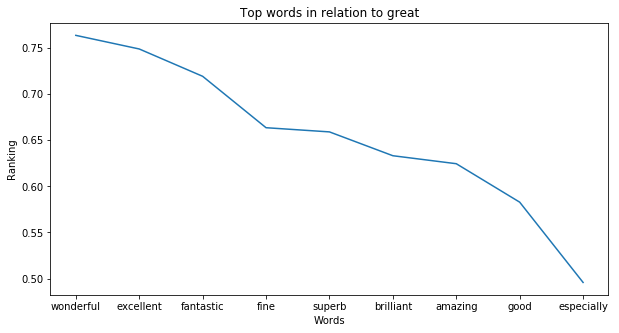

In [111]:
x, y = zip(*a) # unpack a list of pairs into two tuples
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.title('Top words in relation to great')
plt.xlabel('Words')
plt.ylabel('Ranking')
ax.plot(x, y)

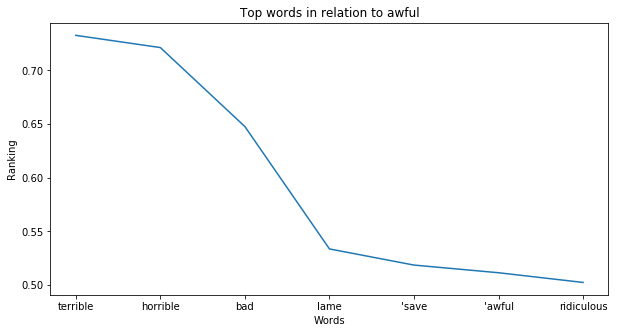

In [112]:
x, y = zip(*b) # unpack a list of pairs into two tuples
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.title('Top words in relation to awful')
plt.xlabel('Words')
plt.ylabel('Ranking')
ax.plot(x, y)

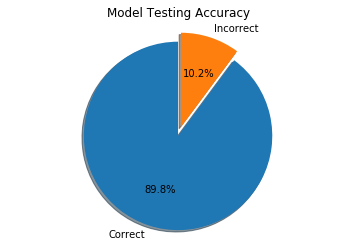

In [115]:
labels = 'Correct', 'Incorrect'
sizes = [89.844, 10.156]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Model Testing Accuracy')
plt.show()

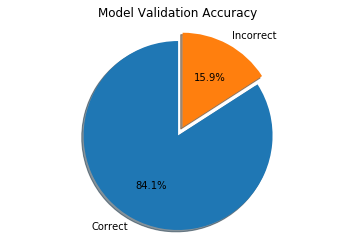

In [117]:
labels = 'Correct', 'Incorrect'
sizes = [84.10, 15.90]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Model Validation Accuracy')
plt.show()

# Conclusion

#### The model is fairly accurate and has good results. 